## Import Statements

In [22]:
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.circuit.library import ZZFeatureMap
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit.library import EfficientSU2
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from math import pi
import rustworkx as rx
from rustworkx.visualization import mpl_draw

## Parametrized Quantum Circuits

We can create a parametrized quantum circuit without binding actual values for parameters as follows:

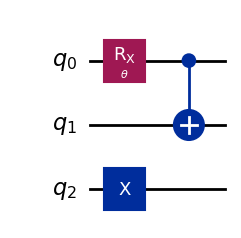

In [7]:
theta = Parameter(r'$\theta$')

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)
qc.draw('mpl')

If we wanted to substitute $\theta = \pi/3$ or $\theta = \pi/2$, we have the following:

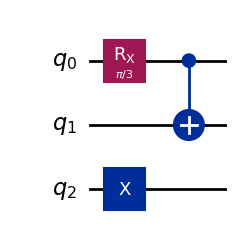

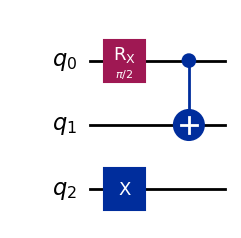

In [9]:
angle_list = [pi / 3, pi / 2]
circuits = [qc.assign_parameters({theta: angle}) for angle in angle_list]

for circuit in circuits:
    display(circuit.draw("mpl"))

## Heuristic Ansatze

### N-Local Circuits

An N-local circuit consists of alternating rotation and entanglement layers where the size of the gates is at most $N$, where $N$ is less than or equal to the total number of qubits. Consider the following example of a 5-Local Circuit of alternating rotation ($RX$ and $CRZ$) and entanglement (Toffoli) operations.

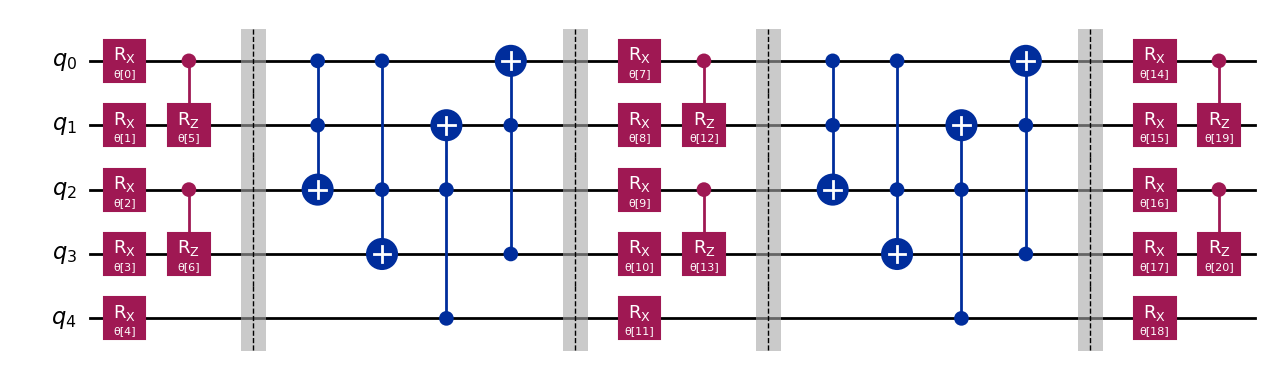

In [14]:
theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

If instead we want a 2-Local circuit, we can use the built in ``TwoLocal`` function.

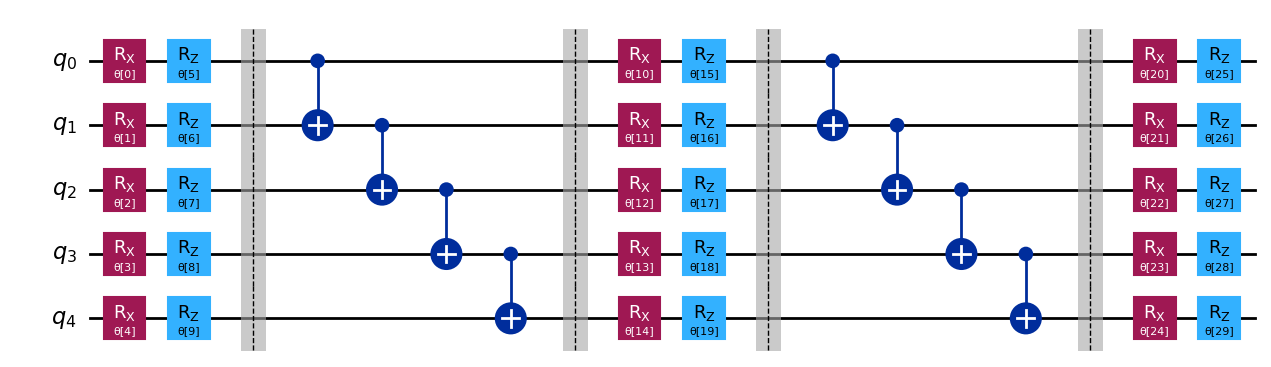

In [15]:
ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

### Efficient SU2 

To construct a hardware-efficient circuit consisting of single-qubit operations spanning the SU(2) group and ``CX`` entanglements, we can use the SU(2) heuristic ansatze. This is a popular choice for classification circuits for machine learning.

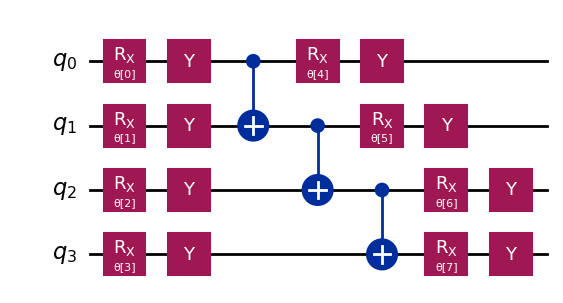

In [17]:
ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

## Problem-specific ansatze

### Max-cut Problem

In the max-cut problem, we aim to find the cut of a graph which maximizes the number of edges between the two blocks. For example, consider the graph below.

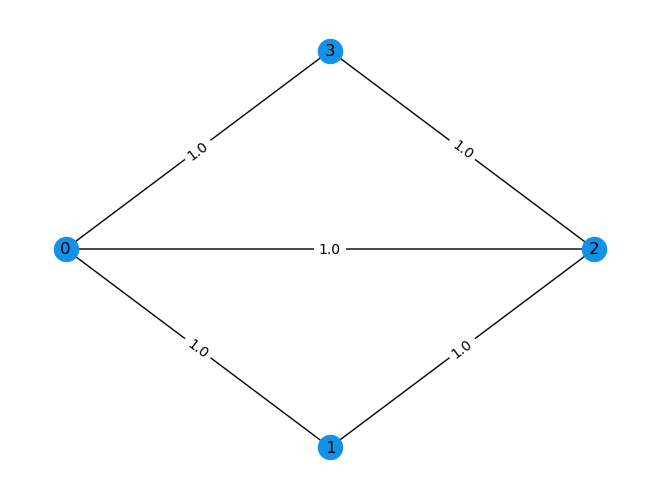

In [21]:
n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)
mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

For the cost in this particular instance, we will use a Pauli Hamiltonian where $Z$'s represent nodes that share an edge. In particular, the Hamiltonian is given as $IIIZZ + IIZIZ + IZIIZ + ZIIIZ$. Using the ``QAOAAnsatz`` provided by Qiskit, we therefore have the following ansatz:

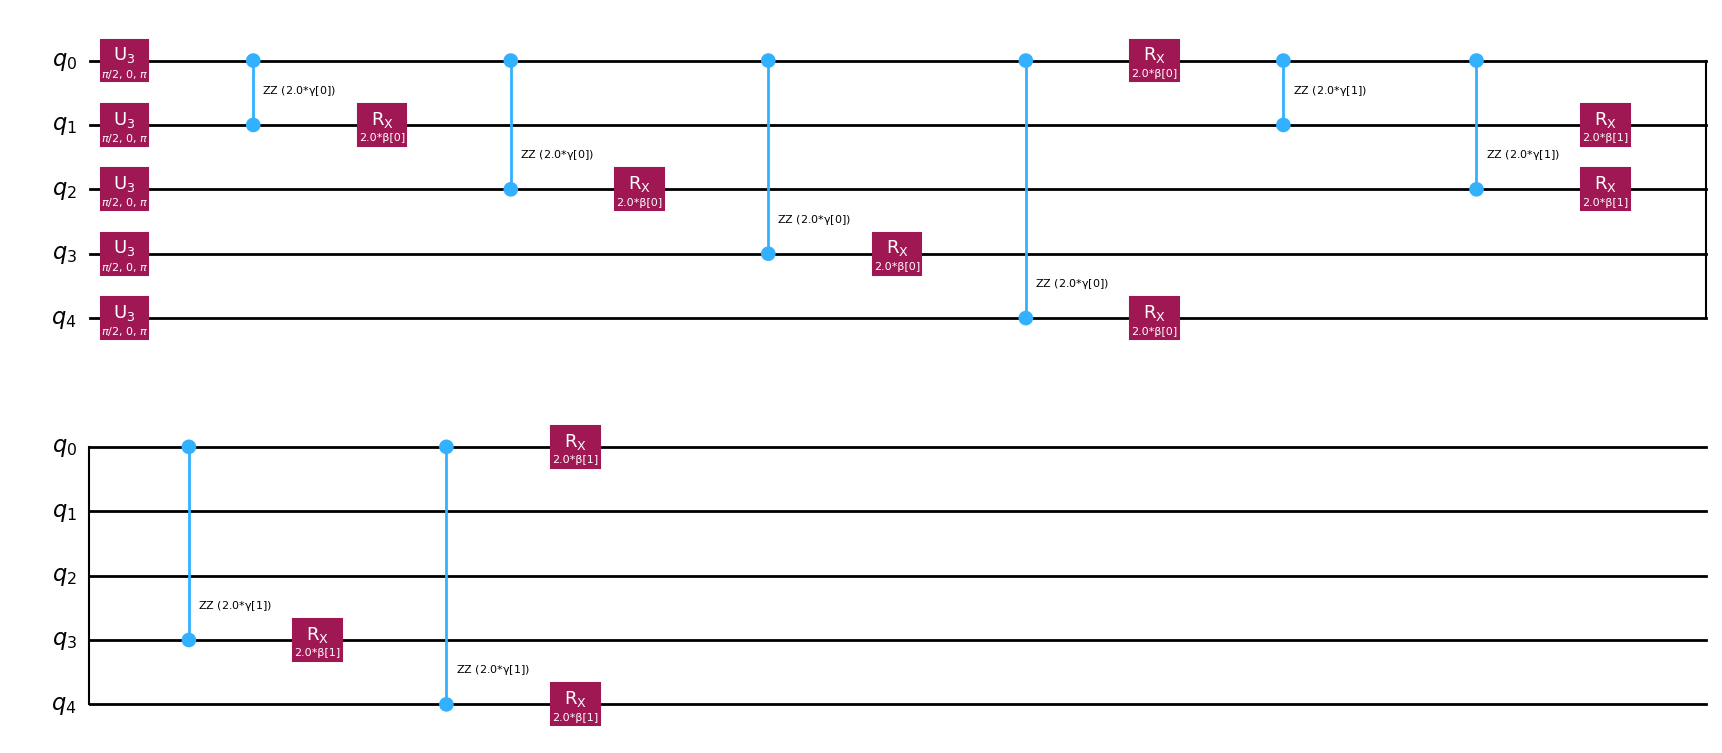

In [23]:
hamiltonian = SparsePauliOp.from_list([("IIIZZ", 1), ("IIZIZ", 1), ("IZIIZ", 1), ("ZIIIZ", 1)])
ansatz = QAOAAnsatz(hamiltonian, reps=2)
ansatz.decompose(reps=3).draw("mpl")

### Quantum Machine Learning

Continuing the example from before, we can combine the ``ZZFeatureMap`` reference with a TwoLocal ansatz.

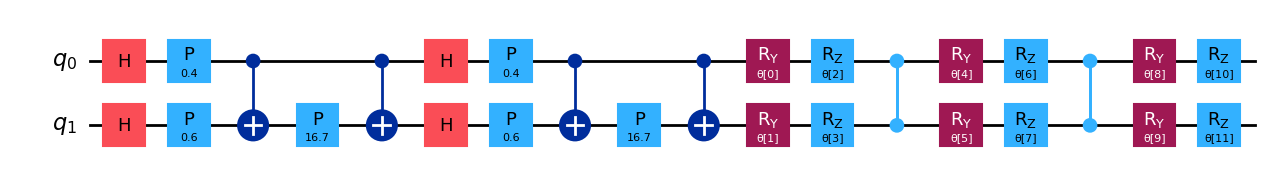

In [18]:
data = [0.2, 0.3]
zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.assign_parameters(data)
variation_form = TwoLocal(2, ["ry", "rz"], "cz", reps=2)
vqc_ansatz = zz_feature_map_reference.compose(variation_form)
vqc_ansatz.decompose().draw("mpl")